In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from submissions.ab_submission.dataLoaders import imageDataLoader
from submissions.ab_submission.object_detector import ObjectDetector
from submissions.ab_submission import dataset
from submissions.ab_submission import follicleDetector

import importlib

from submissions.ab_submission import toolbox

importlib.reload(dataset)
importlib.reload(toolbox)

<module 'submissions.ab_submission.toolbox' from 'c:\\Users\\4078182\\Personal\\git\\follicles_detection\\notebooks\\..\\submissions\\ab_submission\\toolbox.py'>

# Model evaluation

In [2]:
import glob
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
train_files = glob.glob("./data/train/*.jpg")
test_files = glob.glob("./data/test/*.jpg")
train_label = pd.read_csv("./data/train/labels.csv")
test_label = pd.read_csv("./data/test/labels.csv")

In [4]:
import pickle

In [5]:
model = ObjectDetector(ramp_mode=False, verbose_train=True)
model.load(follicleDetector="./params/follicleDetector.pickle",follicleClassifier="./params/follicleClassifier.model")
model.fit(train_files, train_label)
#model.save(follicleDetector="./params/follicleDetector.pickle",follicleClassifier="./params/follicleClassifier.model")

Model loaded from ./params/follicleClassifier.model
Fitting follicleDetector
Fitting follicleClassifier


In [6]:
import numpy as np

In [7]:
np.argmax(np.bincount(np.array([10,11,11,11,1,1,3,3,3,3,2,3,5,6])))

3

In [8]:
test_loader = imageDataLoader(test_files, test_label[["filename","xmin","xmax","ymin","ymax","label"]])
train_loader = imageDataLoader(train_files, train_label[["filename","xmin","xmax","ymin","ymax","label"]])
predict_loader = imageDataLoader(test_files, None)

In [9]:
X_train = train_files
y_train = train_label[["filename","xmin","xmax","ymin","ymax","label"]]

In [10]:
y_hat = model.predict(test_files)

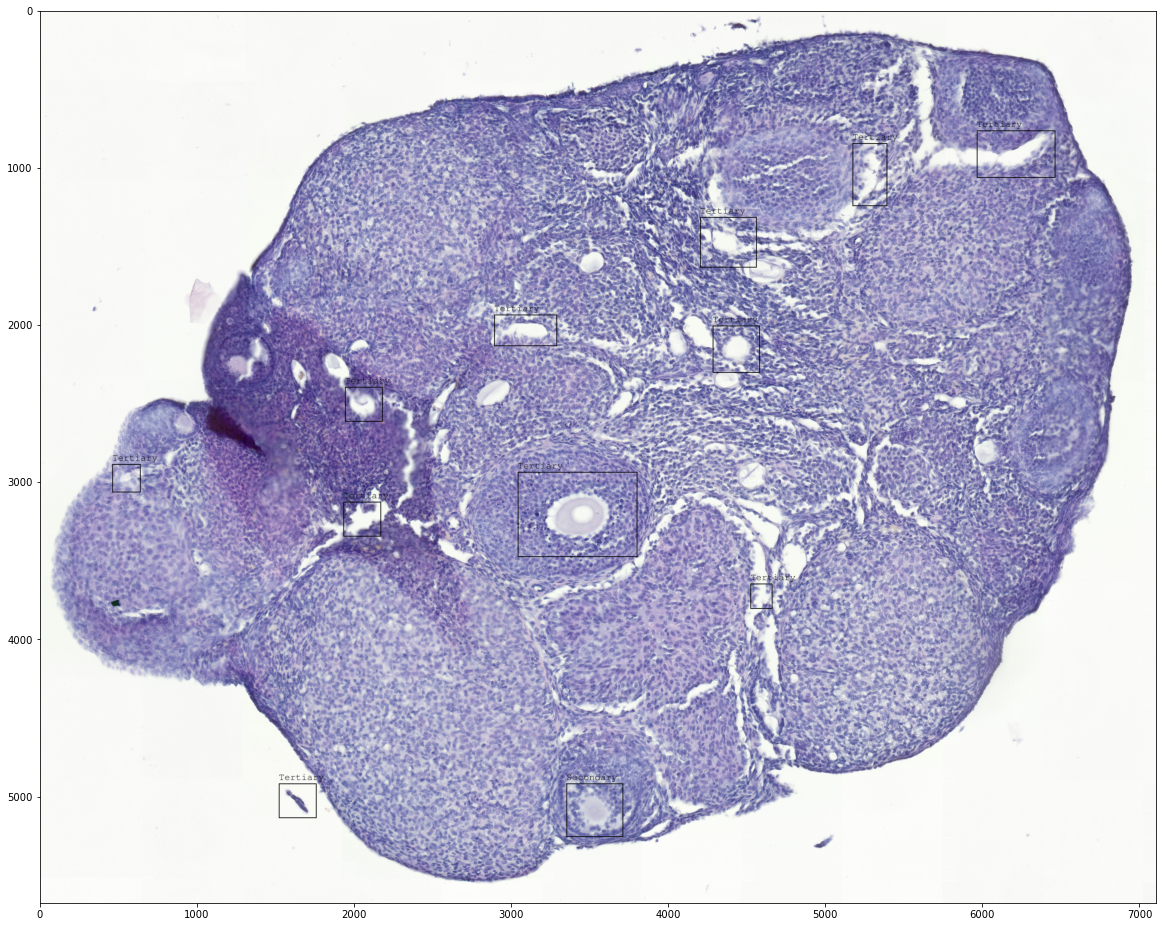

In [11]:
i = 0

for i in range(len(test_loader.X_filenames)):
    image = toolbox.write_rectangle(
        test_loader.get_sample(test_loader.X_filenames[i])[0],
        y_hat[i],
        negative=False,
        folder="test_predicted",
        filename=test_loader.X_filenames[i]
    )

plt.figure(figsize=(20,50))
plt.imshow(image)

In [12]:
follicle_detector = follicleDetector.follicleDetector(gaussian_blur_kernel_size=(25,25))
follicle_detector.fit(X_train, y_train)

In [13]:
def box_loader_wrapper (image_name, image_loader):
    # Get image path
    i = image_loader.X_filenames.index(image_name)
    image_path = [image_loader.X[i]]

    prediction = follicle_detector.predict(image_path)[0][0]

    return prediction

In [14]:
reload_data = False

train_dataset = dataset.folliclesDataset(
    train_loader,
    label_ratio_threshold=0.2,
    data_augmentation=False,
    local_path="./datasets/train_box",
    box_classifier=box_loader_wrapper,
    verbose=False,
    order="box_ratio",
    force_reload=reload_data,
    mode="crop"
)

test_dataset = dataset.folliclesDataset(
    test_loader,
    label_ratio_threshold=0.2,
    data_augmentation=False,
    local_path="./datasets/test_box",
    box_classifier=box_loader_wrapper,
    verbose=False,
    order="box_ratio",
    force_reload=reload_data,
    mode="crop"
)

In [20]:
from torch.utils.data import DataLoader

In [21]:
from torchvision.transforms import RandomCrop, RandomVerticalFlip, RandomHorizontalFlip, Resize

In [22]:
def dataloader_collapse2 (x, image_size_width=256, reducer="random_crop", random_flip=True):
    """dataloader_collate
    
    Function of collate for the DataLoader class use with the datasetFollicles class.
    This function is used to provide images from the datasetFollicles in a tensor for training task.

    Parameters
    ----------
    x: input data to collate, list containing tuple of a numpy array of size (h,w,3) and a dictionnary is expected
    image_size: int, width of the output image
    reducer: str, operation used to fit all the samples in the same tensor : "resize", "random_crop"
    random_flip: boolean, if True, random flip of the images are performed

    Output
    ------
    Tuple containing a tensor of size :
        (batch_size, *features) with features the size of the features data
        (batch_size, 5) with 5 the one-hot encoding of the label
    """

    Xs = []
    Xs_ = []
    ys = []
    min_ratio = np.array([data[1]["bbox_ratio"] for data in x]).mean()

    # Getting the images target size
    ## We try to respect the 128 but adapt to the image size
    if np.array([data[1]["bbox_width"] for data in x]).min() <= image_size_width:
        image_size_width = np.array([data[1]["bbox_width"] for data in x]).min()
    width = image_size_width
    height = int(min_ratio*image_size_width)

    # Getting the operators
    if reducer == "resize":
        reducer_operator = Resize((height, width))
    elif reducer == "random_crop":
        # Recomputing height
        reducer_operator = RandomCrop((height, width), pad_if_needed=True, padding_mode="edge")

    if random_flip:
        random_hflip = RandomHorizontalFlip()
        random_vflip = RandomVerticalFlip()

    for data in x:
        # Getting data in tensor
        data_tensor = torch.tensor(data[0], dtype=torch.float32)
        data_tensor /= 255.
        data_tensor = torch.moveaxis(data_tensor, 2, 0)

        # Cropping or padding it
        data_tensor = reducer_operator(data_tensor)

        # Random transformations
        if random_flip:
            data_tensor = random_hflip(data_tensor)
            data_tensor = random_vflip(data_tensor)

        # extra features
        bbox_ratio = data[1]["bbox_ratio"]
        bbox_relative_size = (data[1]["bbox_width"]*data[1]["bbox_height"])/(data[1]["width"]*data[1]["height"])
        bbox_relative_x_position = data[1]["bbox"][0]/data[1]["width"]
        bbox_relative_y_position = data[1]["bbox"][1]/data[1]["height"]

        # Getting label
        if data[1]["label"] is not None:
            y = nn.functional.one_hot(
                torch.tensor(data[1]["label"].astype("int"), dtype=torch.int64), 
                num_classes=5
            ).float()

            ys.append(y)
        else:
            y = None
        
        Xs.append(data_tensor)
        Xs_.append(torch.tensor([bbox_ratio, bbox_relative_size, bbox_relative_x_position, bbox_relative_y_position], dtype=torch.float32))

    X = torch.stack(Xs)
    X_ = torch.stack(Xs_)
    if y is not None:
        y = torch.stack(ys)

    return (X,X_), y

In [32]:
importlib.reload(dataset)

<module 'submissions.ab_submission.dataset' from '/home/ali/git/follicles_detection/submissions/ab_submission/dataset.py'>

In [33]:
collater2 = lambda x: dataset.dataloader_collapse(x, image_size_width=128, reducer="random_crop", random_flip=True)
collater2_eval = lambda x: dataset.dataloader_collapse(x, image_size_width=128, reducer="resize", random_flip=False)

In [34]:
trainLoader = DataLoader(
    train_dataset,
    batch_size=64,
    collate_fn=collater2,
    shuffle=False
)

testLoader = DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=collater2_eval,
    shuffle=False
)

In [35]:
from torch import nn
from torch import optim
import torch
from torchvision.models import mobilenet_v3_large, resnet18
from torchvision import transforms
import numpy as np

In [57]:
class simple_network(nn.Module):

    def __init__(self):
        super(simple_network, self).__init__()
        
        preprocessing_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
        )
        
        # Creating network
        rn18 = resnet18(pretrained=True)
        rn18_layer = nn.Sequential(*list(rn18.children())[0:-1])
        for param in rn18_layer.parameters():
            param.requires_grad = False
        for param in rn18_layer[-2].parameters():
            param.requires_grad = True

        self.network_features1 = nn.Sequential(*[
            preprocessing_layer,
            rn18_layer,
            nn.Conv2d(in_channels=512, out_channels=100, padding="same", kernel_size=(3,3)),
            nn.Dropout(0.2),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(in_features=100, out_features=25),
            nn.Dropout(0.5),
            nn.LeakyReLU()
        ])

        self.network_features2 = nn.Sequential(*[
            nn.BatchNorm1d(29),
            nn.Linear(in_features=29, out_features=10),
            nn.LeakyReLU(),
            nn.Linear(in_features=10, out_features=5),
            nn.Softmax(dim=1)
        ])

        self.optimizer = optim.Adam(self.parameters(), lr=2e-4, betas=(0.9, 0.99))
        self.loss_fn = nn.CrossEntropyLoss()
        self.loss_history = []

    def forward(self, x):
        
        x, x_ = x
        y_hat_ = self.network_features1(x)
        y_hat = self.network_features2(
            torch.concat([y_hat_, x_], axis=1)
        )

        return y_hat
    
    def fit(self, X,y):

        self.train()
        self.optimizer.zero_grad()

        # Getting y_hat
        y_hat = self.forward(X)

        # Getting loss
        loss_value = self.loss_fn(y_hat, y)
        self.loss_history.append(loss_value.item())

        # Back propagation
        loss_value.backward()
        self.optimizer.step()

    def predict(self, X):

        self.eval()
        with torch.no_grad():
            y_hat = self.forward(X)

            return y_hat

In [58]:
from sklearn.metrics import accuracy_score, f1_score

In [59]:
n_epochs = 100
print_interval = 2

sn = simple_network()
sn.to("cuda:0")

for i in range(n_epochs):
    if (i % print_interval) == 0:
        if len(sn.loss_history) > 0:
            # Getting metrics
            loss = np.array(sn.loss_history).mean()

            y_hats_ = []
            ys_ = []
            for x_, y_ in testLoader:
                x_ = tuple([z.to("cuda:0") for z in x_])
                y_hat_ = sn.predict(x_)
                y_hats_.append(y_hat_.cpu())
                ys_.append(y_)
            y_hats_ = torch.concat(y_hats_)
            ys_ = torch.concat(ys_)

            y_ = np.argmax(ys_, axis=1).numpy()
            y_hat_ = torch.argmax(y_hats_, axis=1).numpy()

            accurary = accuracy_score(y_, y_hat_)
            f1_score_micro = f1_score(y_, y_hat_, average="micro")
            f1_score_macro = f1_score(y_, y_hat_, average="macro")

            print(f"Epoch n°{i} - Loss : {loss}")
            print(f"=== Test metrics : Accuracy : {accurary}, F1-Micro : {f1_score_micro}, F1-Macro : {f1_score_macro}")

    sn.loss_history = []

    for x,y in trainLoader:
        x = tuple([z.to("cuda:0") for z in x])
        y = y.to("cuda:0")
    
        sn.fit(x,y)

Epoch n°2 - Loss : 1.6013235395604914
=== Test metrics : Accuracy : 0.13392857142857142, F1-Micro : 0.13392857142857142, F1-Macro : 0.20659430415206928
Epoch n°4 - Loss : 1.5904746380719272
=== Test metrics : Accuracy : 0.16071428571428573, F1-Micro : 0.16071428571428573, F1-Macro : 0.21521493212669685
Epoch n°6 - Loss : 1.577760934829712
=== Test metrics : Accuracy : 0.20535714285714285, F1-Micro : 0.20535714285714285, F1-Macro : 0.2750537634408602
Epoch n°8 - Loss : 1.563876455480402
=== Test metrics : Accuracy : 0.25892857142857145, F1-Micro : 0.25892857142857145, F1-Macro : 0.3238636363636364
Epoch n°10 - Loss : 1.554063862020319
=== Test metrics : Accuracy : 0.375, F1-Micro : 0.375, F1-Macro : 0.2920751633986928
Epoch n°12 - Loss : 1.542057915167375
=== Test metrics : Accuracy : 0.41964285714285715, F1-Micro : 0.41964285714285715, F1-Macro : 0.448007662835249
Epoch n°14 - Loss : 1.5338619297200984
=== Test metrics : Accuracy : 0.49107142857142855, F1-Micro : 0.49107142857142855, F

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

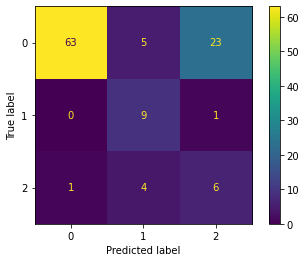

In [50]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_, y_hat_)
).plot()